In [4]:
#Nicely formatted time string
def hms_string(sec_elapsed):
  h = int(sec_elapsed/(60*60))
  m = int((sec_elapsed % (60*60))/60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h,m,s)

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [6]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [7]:
def load_images(path, size = (256,512)):
  src_list, tar_list = list(), list()

  for filename in tqdm(os.listdir(path)):
    pixels = load_img(os.path.join(path, filename), target_size=size)
    pixels = img_to_array(pixels)
    sat_img, map_img = pixels[:,:256], pixels[:,256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
  
  return [np.asarray(src_list), np.asarray(tar_list)]

path = '/content/drive/My Drive/Dataset/maps/train'

filename = 'maps_256.npz'

training_binary_path = os.path.join(path,filename)

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")
  [src_images, tar_images] = load_images(path)
  print("Loaded: ", src_images.shape, tar_images.shape)
  print("Saving training image binary...")
  np.savez_compressed(training_binary_path, src_images, tar_images)
  elapsed = time.time() - start
  print(f'Image preprocess time: {hms_string(elapsed)}')

else:
  print("Loading previous training pickle...")
  train_imgs = np.load(training_binary_path)
  [src_images, tar_images] = train_imgs['arr_0'], train_imgs['arr_1']
  print("Loaded: ", src_images.shape, tar_images.shape)

Loading previous training pickle...
Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


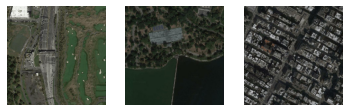

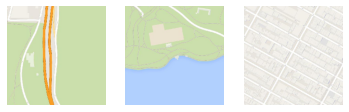

In [5]:
n_samples = 3
for i in range(n_samples):
  plt.subplot(2,n_samples, 1+i)
  plt.axis('off')
  plt.imshow(src_images[i].astype('uint8'))

plt.show()

for i in range(n_samples):
  plt.subplot(2,n_samples, 1+i)
  plt.axis('off')
  plt.imshow(tar_images[i].astype('uint8'))

plt.show()

In [16]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [17]:
def preprocess_imgs(src_images, tar_images):
  #scale from [0,255] to [-1,1]
  src_images = (src_images - 127.5) / 127.5
  tar_images = (tar_images - 127.5) / 127.5
  return [src_images, tar_images]

def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [8]:
def summarize_performance(step, g_model, dataset, n_samples = 3):
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

  #Scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  
  #plot real source images
  for i in range(n_samples):
    plt.subplot(3,n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_realA[i])

  #plot generated images
  for i in range(n_samples):
    plt.subplot(3,n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])

  #plot real target image
  for i in range(n_samples):
    plt.subplot(3,n_samples, 1+ n_samples*2 +i)
    plt.axis('off')
    plt.imshow(X_realB[i])

  save_path = '/content/drive/My Drive/Dataset/maps/'
  #save plot to file
  filename1 = f'plot_{step+1}.png'
  plt.savefig(save_path + filename1)
  plt.close()

  #save generator model
  filename2 = f'model_{step+1}.h5'
  g_model.save(save_path + filename2)
  print(f'Saved: {filename1} and {filename2}')

In [24]:
def train(d_model, g_model, gan_model, dataset, n_epochs = 200, n_batch = 1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  bat_per_epo = int(len(trainA) / n_batch)
  n_steps = bat_per_epo * n_epochs

  for i in range(n_steps):
    #select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    #generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    #update discriminator on real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    #update discriminator on generated(fake) samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    #update generator
    g_loss,_ ,_ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    #Summarize model performance 
    print(f'Epoch {i+1}: d1[{d_loss1}], d2[{d_loss2}], g[{g_loss}]')
    if (i+1)%(bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, dataset)

In [25]:
# load image data
dataset = preprocess_imgs(src_images,tar_images)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
Epoch 137039: d1[9.389336241838464e-07], d2[6.785725048530367e-08], g[0.49339625239372253]
Epoch 137040: d1[1.541548328987119e-07], d2[1.960810465106988e-07], g[4.151881694793701]
Epoch 137041: d1[2.2857329895487055e-07], d2[5.495671473454422e-08], g[1.4844114780426025]
Epoch 137042: d1[2.4480282263539266e-06], d2[9.303856529641052e-08], g[2.8948864936828613]
Epoch 137043: d1[7.981624321473646e-07], d2[1.0702708408416584e-07], g[5.360415935516357]
Epoch 137044: d1[4.118256242691132e-07], d2[1.2696327189587464e-07], g[3.8170745372772217]
Epoch 137045: d1[5.4549005312765075e-08], d2[9.033609558173339e-07], g[3.952350378036499]
Epoch 137046: d1[2.098929314797715e-07], d2[4.0632178865962487e-07], g[2.933530330657959]
Epoch 137047: d1[7.604946858918993e-07], d2[6.283565880949027e-07], g[3.0559241771698]
Epoch 137048: d1[1.0908849645829832e-07], d2[1.9147663010699034e-08], g[2.9413864612579346]
Epoch 137049: d1[4.561584319162648e-06], d2[6.2

KeyboardInterrupt: ignored

In [14]:
from keras.models import load_model

def load_real_samples(filename):
	# load compressed arrays
	data = np.load(path + '/' + filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = np.vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		plt.subplot(1, 3, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i])
		# show title
		plt.title(titles[i])
	plt.show()

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


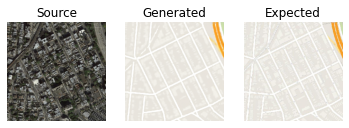

In [20]:
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('/content/drive/My Drive/Dataset/maps/'+'model_131520.h5')
# select random example
ix = np.random.randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)